In [1]:
# imports
%reload_ext autoreload
%autoreload 2

from basic_utils import *

pd.set_option('display.max_rows', 20)

Loading config.json


In [2]:
dates = read_dates('quote') 
# dates[-62:]

In [3]:
UNIT_SCALE = 10**9
tgt_date = [dates[-1]] # hardcoded for now
tgt_date

['2019-02-07']

### load files

In [4]:
latest_quotes = load_csvs('quote_consol', tgt_date)
profile = load_csvs('summary_detail', ['assetProfile'])
latest_keystats = load_csvs('summary_detail', ['defaultKeyStatistics/' + str(tgt_date[0])])
latest_finstats = load_csvs('summary_detail', ['financialData/' + str(tgt_date[0])])

Loading file quote/csv/2019-02-07
Loading file summary-categories/assetProfile
Loading file summary-categories/defaultKeyStatistics/2019-02-07
Loading file summary-categories/financialData/2019-02-07


In [49]:
# profile.info()
# latest_quotes.info()
# latest_keystats.info()
# latest_finstats.info()

### High level overview

#### Basic filtering

In [365]:
profile.columns
pf_cols = ['industry', 'sector', 'symbol']

In [366]:
latest_quotes.columns
qs_cols = ['averageDailyVolume10Day','averageDailyVolume3Month',
           'fiftyDayAverageChangePercent','fiftyTwoWeekHighChangePercent',
           'fiftyTwoWeekLowChangePercent','fiftyTwoWeekRange',
           'longName','regularMarketChangePercent',
           'regularMarketDayHigh','regularMarketDayLow',
           'regularMarketOpen','regularMarketPreviousClose','regularMarketPrice',
           'regularMarketTime','regularMarketVolume','twoHundredDayAverageChangePercent',
           'ytdReturn','expireDate','expireIsoDate','openInterest','marketCap', 'quoteType']
# qs_cols = ['averageDailyVolume10Day','averageDailyVolume3Month',
#            'currency','epsForward','epsTrailingTwelveMonths',
#            'exchange','fiftyDayAverage','fiftyDayAverageChangePercent',
#            'fiftyTwoWeekHighChangePercent','fiftyTwoWeekLowChangePercent',
#            'financialCurrency','forwardPE','longName','market',
#            'marketCap','marketState','priceHint','priceToBook']

In [367]:
latest_keystats.columns
ks_cols = ['beta', 'enterpriseValue', 'pegRatio', 
           'enterpriseToEbitda', '52WeekChange', 'SandP52WeekChange',
           'shortPercentOfFloat', 'netIncomeToCommon']

In [368]:
latest_finstats.columns
fs_cols = ['currentPrice','numberOfAnalystOpinions',
           'totalCash','totalDebt','totalRevenue',
           'freeCashflow','operatingCashflow']

In [369]:
len(latest_quotes), len(profile), len(latest_keystats), len(latest_finstats)

(387, 362, 362, 307)

In [370]:
merged = profile.merge(
    latest_quotes, on=['symbol'], how='inner', sort=False).merge(
    latest_keystats, on=['symbol'], how='inner', sort=False)
# further join but will loose ETFs
# merged = profile.merge(latest_finstats, on=['symbol'], how='inner', sort=False)

# removes all duplicate columns
merged.drop([x for x in merged.columns.tolist() if '_y' in x], axis=1, inplace=True)
merged.rename(index=str, columns={ x: x.split('_')[0] for x in merged.columns}, inplace=True)

merged = merged[pf_cols + qs_cols + ks_cols]
# uncomment if above is enabled
# merged = merged[pf_cols + qs_cols + ks_cols + fs_cols]
merged.set_index('symbol', inplace=True)

In [371]:
# numeric transformations
cast_to_thou = ['averageDailyVolume10Day', 'averageDailyVolume3Month']
cast_to_bil = ['marketCap']
merged[cast_to_thou] = merged[cast_to_thou].divide(10**3).round(1)
merged[cast_to_bil] = merged[cast_to_bil].div(10**9).round(1)
# merged[cast_to_thou + cast_to_bil]
merged['52wkAbsRange'] = merged.fiftyTwoWeekLowChangePercent + abs(merged.fiftyTwoWeekHighChangePercent)

In [382]:
# Companies with an absolte range of [50%] during the last 52 weeks
mask = (merged['52wkAbsRange'] > 0.4) & (merged.quoteType == 'EQUITY')
df = merged[mask]
show = ['52wkAbsRange', 'marketCap',
        'fiftyDayAverageChangePercent','twoHundredDayAverageChangePercent',
        'fiftyTwoWeekLowChangePercent','fiftyTwoWeekHighChangePercent',]
df[show].sort_values(by='fiftyTwoWeekHighChangePercent', ascending=True)
# df[show].hist(figsize=(15,10))
# df = df.groupby(['industry'])[show].median()
df.sort_values(
    by='fiftyTwoWeekHighChangePercent', ascending=False).head(20).round(2)[show]

,52wkAbsRange,marketCap,fiftyDayAverageChangePercent,twoHundredDayAverageChangePercent,fiftyTwoWeekLowChangePercent,fiftyTwoWeekHighChangePercent
symbol,,,,,,
RHT,0.56,31.7,0.02,0.15,0.55,-0.00
CDNS,0.43,14.3,0.13,0.13,0.43,-0.01
NOW,0.66,40.7,0.20,0.23,0.65,-0.01
ANTM,0.44,79.7,0.15,0.14,0.43,-0.01
RNG,0.97,7.8,0.13,0.15,0.96,-0.01
BSX,0.57,53.7,0.08,0.08,0.55,-0.02
MLNX,0.69,5.2,0.11,0.17,0.67,-0.02
WDAY,0.75,40.7,0.12,0.27,0.73,-0.02
MASI,0.58,6.7,0.11,0.11,0.56,-0.02


In [357]:
tgt_industry = 'Electronic Gaming & Multimedia'
merged[merged.industry == tgt_industry][show]

,52wkAbsRange,fiftyDayAverageChangePercent,fiftyTwoWeekLowChangePercent,fiftyTwoWeekHighChangePercent,twoHundredDayAverageChangePercent,marketCap
symbol,,,,,,
ATVI,0.514493,-0.065217,0.033623,-0.480869,-0.300767,33.5
EA,0.581874,-0.022227,0.137870,-0.444004,-0.180115,25.4
TTWO,0.364615,-0.073451,0.053558,-0.311057,-0.182461,11.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x129a15080>,
      dtype=object)

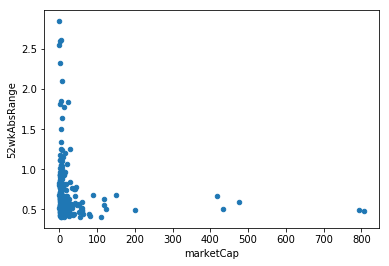

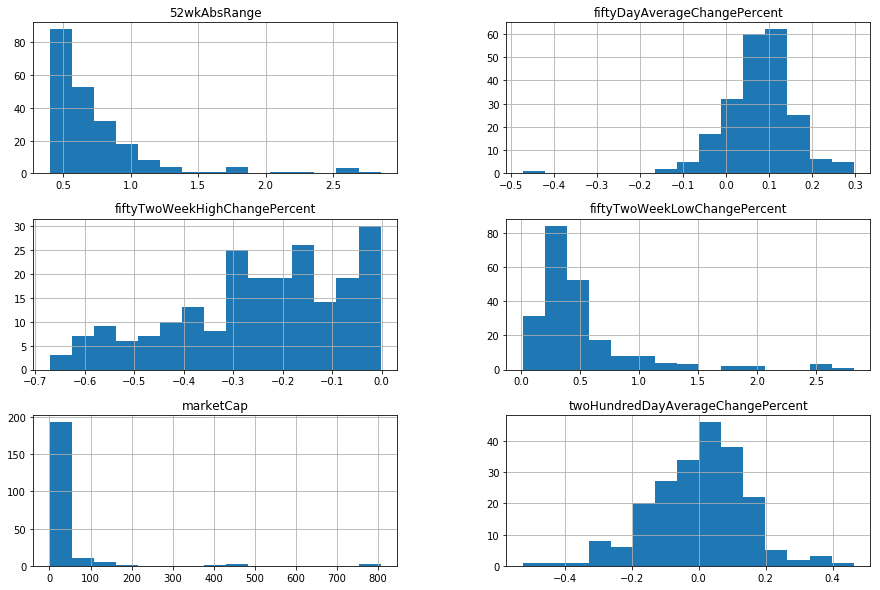

In [358]:
mask = (merged['52wkAbsRange'] > .4) & (merged.quoteType=='EQUITY')
df = merged[mask]
df.plot.scatter(x='marketCap', y='52wkAbsRange')
df.hist(show, bins=15, figsize=(15,10))

In [227]:
merged.to_csv('merged-universe.csv')
merged.columns

Index(['industry', 'sector', 'averageDailyVolume10Day',
       'averageDailyVolume3Month', 'fiftyDayAverageChangePercent',
       'fiftyTwoWeekHighChangePercent', 'fiftyTwoWeekLowChangePercent',
       'fiftyTwoWeekRange', 'longName', 'regularMarketChangePercent',
       'regularMarketDayHigh', 'regularMarketDayLow', 'regularMarketOpen',
       'regularMarketPreviousClose', 'regularMarketPrice', 'regularMarketTime',
       'regularMarketVolume', 'twoHundredDayAverageChangePercent', 'ytdReturn',
       'expireDate', 'expireIsoDate', 'openInterest', 'marketCap', 'quoteType',
       'beta', 'enterpriseValue', 'pegRatio', 'enterpriseToEbitda',
       '52WeekChange', 'SandP52WeekChange', 'shortPercentOfFloat',
       'netIncomeToCommon', '52wkAbsRange'],
      dtype='object')

### Expanded Universe

In [2]:
data = pd.read_csv('./csvs/expanded_universe.csv', skiprows=2)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1165 entries, 0 to 1164
Data columns (total 17 columns):
Symbol                      1165 non-null object
BEST_CRNCY_ISO              1165 non-null object
NAME                        1165 non-null object
TRAIL_12M_FREE_CASH_FLOW    1098 non-null float64
NET_DEBT_TO_EBITDA          982 non-null float64
CRNCY_ADJ_MKT_CAP           1165 non-null int64
NET_DEBT                    1165 non-null object
VOLATILITY_30D              1163 non-null float64
PEG1                        1165 non-null object
PEG2                        1165 non-null object
GICS_SECTOR_NAME            1165 non-null object
GICS_INDUSTRY_NAME          1165 non-null object
GICS_INDUSTRY_GROUP_NAME    1165 non-null object
TOT_ANALYST_REC             1165 non-null float64
ASSET_TURNOVER              1151 non-null object
RETURN_COM_EQY              1165 non-null object
Filtered?                   1105 non-null object
dtypes: float64(4), int64(1), object(12)
memory usage: 154

In [3]:
full_list = data.Symbol.apply(lambda x: x.split(" ")[0]).tolist()
data['ticker'] = full_list
data.set_index('ticker', drop=False, inplace=True)
data.head()

,Symbol,BEST_CRNCY_ISO,NAME,TRAIL_12M_FREE_CASH_FLOW,NET_DEBT_TO_EBITDA,CRNCY_ADJ_MKT_CAP,NET_DEBT,VOLATILITY_30D,PEG1,PEG2,GICS_SECTOR_NAME,GICS_INDUSTRY_NAME,GICS_INDUSTRY_GROUP_NAME,TOT_ANALYST_REC,ASSET_TURNOVER,RETURN_COM_EQY,Filtered?,ticker
ticker,,,,,,,,,,,,,,,,,,
PENN,PENN US Equity,USD,PENN NATIONAL GAMING INC,0.3,5.5,3,5,61.5,0.18,0.33,Consumer Discretionary,"Hotels, Restaurants & Leisure",Consumer Services,12.0,60%,(123),116,PENN
MAT,MAT US Equity,USD,MATTEL INC,-1.2,NaN,5,2,37.6,(1.42),0.03,Consumer Discretionary,Leisure Products,Consumer Durables & Apparel,17.0,79%,(79),134,MAT
PAM,PAM US Equity,ARS,PAMPA ENERGIA SA-SPON ADR,-0.1,NaN,3,1,56.2,0.00,0.00,Utilities,Electric Utilities,Utilities,12.0,68%,(70),299,PAM
GE,GE US Equity,USD,GENERAL ELECTRIC CO,-0.8,NaN,71,63,54.1,0.48,0.62,Industrials,Industrial Conglomerates,Capital Goods,24.0,35%,(62),746,GE
NWL,NWL US Equity,USD,NEWELL BRANDS INC,0.8,NaN,10,10,62.0,(1.12),0.88,Consumer Discretionary,Household Durables,Consumer Durables & Apparel,13.0,40%,(58),119,NWL


In [4]:
remove = ['700', '9984', 'FOX', 'BF/B', 'CIB', 'EC', 'MBT', 
          'OGZPY', 'EGN', 'CELG', 'COL', 'BF/B', 'PBR/A', 
          'RDS/A', 'MOG/A', 'LPNT', 'AET', 'BRK/B', 'TKPYY', 
          'JW/A', 'ESRX', 'LHO', 'RDS/B','BFR','BMA','GGAL',
          'PAM', 'YPF', 'ABEV','AZUL', 'BAK', 'BBD', 'BDORY', 
'BFR', 'BMA', 'BRFS', 'BSBR', 'CBD', 'CIB', 'CIG', 'CIOXY', 'EBR', 'EC', 
'ERIC', 'ERJ', 'FBR', 'GGAL', 'GGB', 'HDB', 'IBN', 'ITUB', 'MBT', 'NVO', 
'OGZPY','PAM', 'PBR', 'SBS', 'SID', 'TKC', 'TSU', 'TTM', 'UGP', 'VALE','VEDL','VIV', 'WIT', 'YPF']
data.drop(remove, inplace=True, errors='ignore')

In [5]:
existing_cos = config['companies']
len(data.ticker.tolist()), len(existing_cos)
s = set(data.ticker.tolist())
new_tickers = s.difference(existing_cos)

In [58]:
dataset = 'quote'
full_data = []
fail_tickers = []
for x in list(new_tickers):
    print('Getting quote for', x)
    encoded_kv = urllib.parse.urlencode({QUERY_DICT[dataset][enc_key]: x})
    try:
        data = get_data(encoded_kv, dataset, '')
        full_data.extend(get_children_list(json.loads(data), 'quoteResponse'))
    except Exception as e:
        print(e)
        fail_tickers.append(x)

division by zero
division by zero
division by zero


In [7]:
# fail_tickers = ['EGN', 'CELG', 'COL', 'BF/B', 'PBR/A', 'RDS/A', 'MOG/A', 'LPNT', 'AET', 'BRK/B', 'TKPYY', 'JW/A', 'ESRX', 'LHO', 'RDS/B']
fail_tickers = remove

In [9]:
extended_univ = new_tickers.difference(set(fail_tickers)).union(set(existing_cos))
print('Full new list without duplicates {}'.format(len(extended_univ)))
print(sorted(list(extended_univ)))

Full new list without duplicates 1231
['0700.HK', '1810.HK', '3690.HK', '9984.T', 'A', 'AAL', 'AAN', 'AAON', 'AAP', 'AAPL', 'AAXN', 'ABB', 'ABBV', 'ABC', 'ABCB', 'ABEV', 'ABMD', 'ABT', 'ACC', 'ACHC', 'ACIW', 'ACM', 'ACN', 'ADBE', 'ADC', 'ADI', 'ADM', 'ADNT', 'ADP', 'ADS', 'ADSK', 'AEE', 'AEIS', 'AEL', 'AEO', 'AEP', 'AES', 'AFG', 'AFL', 'AGCO', 'AGN', 'AHL', 'AIG', 'AIN', 'AIT', 'AIV', 'AIZ', 'AJG', 'AJRD', 'AKAM', 'AKR', 'ALB', 'ALE', 'ALGN', 'ALK', 'ALL', 'ALLE', 'ALLO', 'ALRM', 'ALXN', 'AMAT', 'AMCX', 'AMD', 'AME', 'AMED', 'AMG', 'AMGN', 'AMN', 'AMP', 'AMRN', 'AMT', 'AMX', 'AMZN', 'AN', 'ANET', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'APC', 'APD', 'APH', 'APTV', 'APY', 'ARE', 'ARI', 'ARNC', 'ARRS', 'ARW', 'ASB', 'ASGN', 'ASH', 'ASX', 'ATGE', 'ATHM', 'ATI', 'ATO', 'ATR', 'ATVI', 'AU', 'AUO', 'AVA', 'AVAV', 'AVB', 'AVGO', 'AVNS', 'AVT', 'AVX', 'AVY', 'AWK', 'AWR', 'AXE', 'AXP', 'AYI', 'AYX', 'AZN', 'AZO', 'AZUL', 'B', 'BA', 'BABA', 'BAC', 'BAESY', 'BAK', 'BANR', 'BASFY', 'BAX', 'BAYRY', '

### Old overview of companies in the coverage universe

- [x] Produce a list with an overview of all the companies in the coverage universe (name, symbol, address, sector, industry, description, employees)

In [6]:
profile = profile.drop_duplicates(subset='symbol')

In [7]:
len(profile.symbol.unique())

362

In [8]:
len(profile), len(profile.symbol.unique())

(362, 362)

In [12]:
brief_cols = ['symbol', 'website', 'address', 'sector', 'fullTimeEmployees', 'longBusinessSummary']

p2 = profile.copy()
p2['address'] = p2.address1 + ', ' \
    + p2.city + ', ' + p2.state + ', ' \
    + p2.zip + ', ' + p2.country
p2['sector'] = p2['sector'] + ', ' + p2['industry']

In [13]:
long_tickers = ["TSLA", "TAL", "SYMC", "AMAT", "MU", "CELG", "BABA", "FB", 
                "EDU", "ALLY", "GOOG", "CFG", "WDC", "SFTBY", "LRCX", "BAC", 
                "WFC", "KEY", "GM", "SHY", "SRLN", "NXPI", "XRAY", "TCEHY"]

In [14]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.html.border', 0)

sorted_symbols = profile.sort_values(by=['sector','industry']).symbol.tolist()
# sorted_symbols = long_tickers

with open('company-overviews.html', mode='w') as f:
    for s in sorted_symbols:
        f.write(p2[p2.symbol == s][brief_cols].T.to_html())
        f.write('<p style="page-break-before: always">')
    f.close()

pd.set_option('display.max_colwidth', 50)

In [15]:
risk_cols = ['symbol', 'auditRisk', 'boardRisk', 'compensationRisk', 'shareHolderRightsRisk', 'overallRisk']
profile[risk_cols].sort_values(by=['shareHolderRightsRisk'], ascending=False).head(10)

,symbol,auditRisk,boardRisk,compensationRisk,shareHolderRightsRisk,overallRisk
308,RL,1.0,9.0,10.0,10.0,10.0
293,PSTG,2.0,9.0,9.0,10.0,10.0
270,NWSA,1.0,9.0,5.0,10.0,10.0
269,NWS,1.0,9.0,5.0,10.0,10.0
62,CAG,1.0,6.0,5.0,10.0,8.0
27,APPF,2.0,7.0,8.0,10.0,10.0
96,DATA,1.0,5.0,10.0,10.0,10.0
255,NFLX,2.0,10.0,10.0,10.0,10.0
242,MSG,1.0,10.0,10.0,10.0,10.0
103,DLB,1.0,4.0,3.0,10.0,7.0


In [16]:
date_cols = ['governanceEpochDate', 'compensationAsOfEpochDate']
profile.fillna(0, inplace=True)
profile.governanceEpochDate.apply(lambda x: date.fromtimestamp(x)).value_counts()
profile.compensationAsOfEpochDate.apply(lambda x: date.fromtimestamp(x)).value_counts()

2017-12-30    254
2018-12-30     94
1969-12-31     77
2016-12-30      4
2015-12-30      1
2005-12-30      1
Name: compensationAsOfEpochDate, dtype: int64

- [x] What is the distribution (frequency) of companies by sector and industry?

In [17]:
profile.sector.value_counts()

Technology                159
Healthcare                110
0                          56
Consumer Cyclical          54
Consumer Defensive         30
Industrials                16
Financial Services          5
Communication Services      1
Name: sector, dtype: int64

In [18]:
count_by_ind = profile.groupby(by=['sector', 'industry']).symbol.count().sort_index()
with open('universe.html', mode='w') as f:
    f.write(pd.DataFrame(count_by_ind).to_html())
    f.close()
count_by_ind

sector                  industry                           
0                       0                                      56
Communication Services  Telecom Services                        1
Consumer Cyclical       Apparel Manufacturing                   2
                        Apparel Stores                          8
                        Auto Manufacturers                      5
                        Auto Parts                              7
                        Broadcasting - TV                       2
                        Footwear & Accessories                  5
                        Home Improvement Stores                 2
                        Leisure                                 8
                                                               ..
Technology              Electronic Gaming & Multimedia          4
                        Health Information Services             6
                        Information Technology Services         3
                

#### Old analytics

- [x] Sum key metrics by sector (market cap, revenues, income, cash flow, …) to understand  relevant size

In [51]:
# current date is dirty, new dates won't include these tickers
# merged[merged.symbol == 'ZG']
# merged.drop('185', inplace=True) # MTRX
# merged.drop('313', inplace=True) # Z
# merged.drop('315', inplace=True) # ZG
# merged.drop(['246','97','230','90'], inplace=True) # SAND, EMN, PX, DWDP
# merged.drop(['174','134','162'], inplace=True) # MGTI, HLAN, LC
# merged.drop(['48','234','53', '143'], inplace=True) # CALL, RDCM, CELL, IDCC
# merged.drop(['83','118','292', '178'], inplace=True) # DE, GE, UPS, MMM
# merged.drop(['249','47','286', '63'], inplace=True) # SHAK, CAKE, TXRH, CMG

# CRS, ATI, HRB, VAC, THO, PRLB, TREE, CVCO, KTOS, CSU
# merged.drop(['90','35', '173', '369', '340', '290', '345', '98', '209', '95'], inplace=True) 
# merged.drop(['70'], inplace=True) # CEL

# merged[merged.symbol != 'AAPL']
merged[merged.sector == 'Financial Services'].sort_values(by='marketCap')

,symbol,sector,industry,marketCap,shortName,trailingPE,regularMarketPrice,trailingAnnualDividendYield,earningsTimestamp,earningsTimestampEnd,...,earningsGrowth,revenueGrowth,revenuePerShare,grossMargins,ebitdaMargins,operatingMargins,profitMargins,targetMeanPrice,targetMedianPrice,numberOfAnalystOpinions
338,TSS,Financial Services,Credit Services,16948457472,"Total System Services, Inc.",26.402388,92.91,0.005739,1.540325e+09,1.548450e+09,...,0.250,-0.176,24.745,0.32041,0.22987,0.17240,0.14385,106.73,109.5,22.0
173,ICE,Financial Services,Financial Exchanges,44746518528,Intercontinental Exchange Inc.,18.385210,78.56,0.011268,1.549546e+09,1.525696e+09,...,0.100,0.056,8.161,1.00000,0.62432,0.53997,0.52819,86.09,85.0,16.0
282,PYPL,Financial Services,Credit Services,103966711808,"PayPal Holdings, Inc.",51.000000,88.23,NaN,1.539877e+09,1.549298e+09,...,0.161,0.137,12.568,0.46777,0.19848,0.16588,0.13982,99.33,100.0,42.0
208,MA,Financial Services,Credit Services,215068196864,Mastercard Incorporated,46.701054,208.24,0.004871,1.540903e+09,1.549287e+09,...,0.364,0.200,13.246,1.00000,0.58825,0.55464,0.33809,233.75,230.0,36.0
354,V,Financial Services,Credit Services,320854753280,Visa Inc.,35.341793,144.76,0.005860,1.540411e+09,1.549314e+09,...,0.162,0.148,8.881,0.96680,0.68267,0.66710,0.47908,164.37,165.0,35.0


In [52]:
# check for companies with less than 100M of revenue
merged[merged.marketCap < (0.5 * UNIT_SCALE)].sort_values(by=['sector','industry']).industry.value_counts()
# merged[merged.marketCap < (0.5 * UNIT_SCALE)].sort_values(by=['sector','industry']).marketCap / UNIT_SCALE
# merged[merged.totalRevenue < (0.1 * UNIT_SCALE)].sort_values(by=['sector','industry'])[['symbol', 'shortName', 'industry']]

Biotechnology                          16
Communication Equipment                 2
Semiconductor Equipment & Materials     2
Diagnostics & Research                  1
Computer Systems                        1
Diversified Industrials                 1
Medical Care                            1
Software - Application                  1
Name: industry, dtype: int64

In [53]:
merged.industry.value_counts()

Biotechnology                          44
Software - Application                 41
Semiconductors                         26
Software - Infrastructure              21
Diagnostics & Research                 18
Communication Equipment                13
Internet Content & Information         12
Medical Instruments & Supplies         11
Specialty Retail                       11
Medical Devices                        11
                                       ..
Consumer Electronics                    2
Broadcasting - TV                       2
Beverages - Wineries & Distilleries     2
Pharmaceutical Retailers                1
Grocery Stores                          1
Luxury Goods                            1
Semiconductor Memory                    1
Telecom Services                        1
Food Distribution                       1
Financial Exchanges                     1
Name: industry, Length: 51, dtype: int64

In [54]:
merged.columns

Index(['symbol', 'sector', 'industry', 'marketCap', 'shortName', 'trailingPE',
       'regularMarketPrice', 'trailingAnnualDividendYield',
       'earningsTimestamp', 'earningsTimestampEnd', 'earningsTimestampStart',
       'epsForward', 'epsTrailingTwelveMonths', 'fiftyDayAverageChangePercent',
       'fiftyTwoWeekHighChangePercent', 'fiftyTwoWeekLowChangePercent',
       'priceToBook', 'twoHundredDayAverageChangePercent', 'enterpriseValue',
       'forwardPE', 'pegRatio', 'enterpriseToEbitda', '52WeekChange',
       'SandP52WeekChange', 'shortPercentOfFloat', 'netIncomeToCommon',
       'ebitda', 'totalCashPerShare', 'totalDebt', 'totalRevenue',
       'returnOnAssets', 'returnOnEquity', 'grossProfits', 'freeCashflow',
       'operatingCashflow', 'earningsGrowth', 'revenueGrowth',
       'revenuePerShare', 'grossMargins', 'ebitdaMargins', 'operatingMargins',
       'profitMargins', 'targetMeanPrice', 'targetMedianPrice',
       'numberOfAnalystOpinions'],
      dtype='object')

In [55]:
grouping = ['sector', 'industry']
display_scale = ['marketCap','totalRevenue','netIncomeToCommon', 'freeCashflow']
df = merged.groupby(by=grouping)[display_scale]
(df.sum().sort_values(by='freeCashflow', ascending=False) / UNIT_SCALE).round(2)

marketCap  \
sector             industry                                        
Technology         Internet Content & Information        1735.06   
                   Consumer Electronics                  1001.08   
                   Semiconductors                        1057.89   
                   Software - Infrastructure             1160.30   
Healthcare         Drug Manufacturers - Major            1175.68   
Consumer Cyclical  Specialty Retail                      1405.66   
Healthcare         Health Care Plans                      641.87   
                   Biotechnology                          497.59   
Financial Services Credit Services                        656.84   
Consumer Defensive Discount Stores                        416.67   
...                                                          ...   
Technology         Scientific & Technical Instruments      44.44   
Consumer Defensive Grocery Stores                          24.98   
Consumer Cyclical  Broadcasting - TV                       15.78   
                   Apparel Manufacturing                   16.75   
Technology         Health Information Services             53.98   
Consumer Cyclical  Luxury Goods                            14.33   
Industrials        Aerospace & Defense                     12.97   
Consumer Defensive Education & Training Services           42.74   
Healthcare         Medical Care                            73.78   
Consumer Cyclical  Auto Manufacturers                     385.61   

                                                       totalRevenue  \
sector             industry                                           
Technology         Internet Content & Information            242.78   
                   Consumer Electronics                      256.25   
                   Semiconductors                            230.69   
                   Software - Infrastructure                 170.05   
Healthcare         Drug Manufacturers - Major                252.30   
Consumer Cyclical  Specialty Retail                          404.64   
Healthcare         Health Care Plans                         742.37   
                   Biotechnology                              88.82   
Financial Services Credit Services                            53.47   
Consumer Defensive Discount Stores                           652.90   
...                                                             ...   
Technology         Scientific & Technical Instruments         12.33   
Consumer Defensive Grocery Stores                            124.18   
Consumer Cyclical  Broadcasting - TV                          18.05   
                   Apparel Manufacturing                       8.84   
Technology         Health Information Services                 8.40   
Consumer Cyclical  Luxury Goods                                4.42   
Industrials        Aerospace & Defense                         5.93   
Consumer Defensive Education & Training Services               9.60   
Healthcare         Medical Care                               75.21   
Consumer Cyclical  Auto Manufacturers                        778.50   

                                                       netIncomeToCommon  \
sector             industry                                                
Technology         Internet Content & Information                  50.91   
                   Consumer Electronics                            56.18   
                   Semiconductors                                  47.85   
                   Software - Infrastructure                       20.94   
Healthcare         Drug Manufacturers - Major                      32.08   
Consumer Cyclical  Specialty Retail                                17.75   
Healthcare         Health Care Plans                               28.82   
                   Biotechnology                                   10.68   
Financial Services Credit Services                                 16.72   
Consumer Defensive D

In [56]:
display_performance = ['fiftyDayAverageChangePercent', 
                       'twoHundredDayAverageChangePercent',
                       'fiftyTwoWeekHighChangePercent', 
                       'fiftyTwoWeekLowChangePercent']

df = merged.groupby(by='sector')[display_performance].mean()
# df.rank().mean(axis=1)
df.T

sector,Communication Services,Consumer Cyclical,Consumer Defensive,Financial Services,Healthcare,Industrials,Technology
fiftyDayAverageChangePercent,-0.168181,0.000432,0.040209,0.017481,-0.013025,-0.024346,-0.014234
twoHundredDayAverageChangePercent,-0.073107,-0.025722,0.040992,0.040785,0.003797,0.027017,-0.030537
fiftyTwoWeekHighChangePercent,-0.238039,-0.200845,-0.145887,-0.051497,-0.205791,-0.142487,-0.212389
fiftyTwoWeekLowChangePercent,0.106835,0.424114,0.324125,0.327646,0.477213,0.302242,0.407627


- [x] Show metrics of dispersion for key metrics by sector (same as above) to under ranges and define focus, limitations for research and investment parameters

In [57]:
from pandas import Series
# range_func = lambda x: Series([x.min(), x.mean(), x.median(), x.max()], index =['count', 'min', 'mean', 'median', 'max'])
df_range = merged.groupby(by='sector').marketCap.describe()
df_range[df_range.columns[1:]] = (df_range[df_range.columns[1:]] / UNIT_SCALE).round(1)
df_range

,count,mean,std,min,25%,50%,75%,max
sector,,,,,,,,
Communication Services,1.0,85.3,NaN,85.3,85.3,85.3,85.3,85.3
Consumer Cyclical,54.0,51.9,129.9,1.8,5.9,10.7,37.3,858.4
Consumer Defensive,30.0,47.9,67.5,3.2,13.6,23.6,38.9,305.6
Financial Services,5.0,140.3,126.3,16.9,44.7,104.0,215.1,320.9
Healthcare,114.0,32.7,58.3,0.0,1.4,11.2,42.8,388.1
Industrials,16.0,17.2,16.6,0.1,5.3,15.1,22.7,64.9
Technology,161.0,41.2,129.2,0.0,2.9,7.3,21.5,998.3


In [58]:
df_range = merged.groupby(by='sector')[display_scale].describe()
df_range[df_range.columns[1:]] = (df_range[df_range.columns[1:]] / UNIT_SCALE).round(1)
df_range.T

sector                   Communication Services  Consumer Cyclical  \
marketCap         count                     1.0               54.0   
                  mean                     85.3               51.9   
                  std                       NaN              129.9   
                  min                      85.3                1.8   
                  25%                      85.3                5.9   
                  50%                      85.3               10.7   
                  75%                      85.3               37.3   
                  max                      85.3              858.4   
totalRevenue      count                     0.0                0.0   
                  mean                     84.0               30.7   
...                                         ...                ...   
netIncomeToCommon 75%                      12.0                1.3   
                  max                      12.0               22.9   
freeCashflow      count                     0.0                0.0   
                  mean                     17.1                0.9   
                  std                       NaN                3.7   
                  min                      17.1              -13.0   
                  25%                      17.1                0.1   
                  50%                      17.1                0.3   
                  75%                      17.1                1.0   
                  max                      17.1               14.0   

sector                   Consumer Defensive  Financial Services  Healthcare  \
marketCap         count                30.0                 5.0       114.0   
                  mean                 47.9               140.3        32.7   
                  std                  67.5               126.3        58.3   
                  min                   3.2                16.9         0.0   
                  25%                  13.6                44.7         1.4   
                  50%                  23.6               104.0        11.2   
                  75%                  38.9               215.1        42.8   
                  max                 305.6               320.9       388.1   
totalRevenue      count                 0.0                 0.0         0.0   
                  mean                 44.2                11.6        18.0   
...                                     ...                 ...         ...   
netIncomeToCommon 75%                   3.0                 4.7         0.8   
                  max                  10.7                 9.3        22.5   
freeCashflow      count                 0.0                 0.0         0.0   
                  mean                  1.9                 4.2         1.3   
                  std                   3.4                 4.2         2.4   
                  min                  -0.7                 0.6        -4.7   
                  25%                   0.6                 0.7        -0.0   
                  50%                   0.8                 2.3         0.3   
                  75%                   1.7                 6.9         1.4   
                  max                  17.3                10.3        14.6   

sector                   Industrials  Technology  
marketCap         count         16.0       161.0  
                  mean          17.2        41.2  
                  std           16.6       129.2  
                  min            0.1         0.0  
                  25%            5.3         2.9  
                  50%           15.1         7.3  
                  75%           22.7        21.5  
                  max           64.9       998.3  
totalRevenue      count          0.0         0.0  
                  mean           4.7         8.7  
...                              ...         ...  
netIncomeToCommon 75%            0.9         0.5  
                  max            1.6        56.1  
freeCa

In [ ]:
sector_des = merged[merged.sector == 'Technology'][display_scale].describe().T
sector_des[sector_des.columns[1:]] = (sector_des[sector_des.columns[1:]] / UNIT_SCALE).round(1)
sector_des

In [ ]:
display_scale

In [ ]:
# financial metrics for companies are not correctly calculated, see FB and MU
sector_des = merged[merged.sector == 'Technology'][['symbol', 'industry'] + display_scale]
sector_des[sector_des.columns[2:]]  = (sector_des[sector_des.columns[2:]] / UNIT_SCALE).round(1)
sector_des.sort_values(by='freeCashflow', ascending=False)

- [x] Display top winners and losers for the last 52 weeks

In [ ]:
merged.columns

In [ ]:
cols = ['symbol', 'shortName', 'sector', 'industry', 'marketCap', 
        'fiftyTwoWeekLowChangePercent', 'enterpriseToEbitda', 'forwardPE', 'pegRatio']
# top / bottom 52wk performing by sectors & industries
merged.groupby(by=grouping).fiftyTwoWeekLowChangePercent.mean().sort_values()

In [ ]:
# top / bottom 52wk performing by company
merged.sort_values(by='fiftyTwoWeekLowChangePercent')[cols]

- [ ] Plot key return / performance metrics by market cap, revenues and cashflows

In [ ]:
merged[merged.industry == 'Solar']

In [ ]:
merged.columns

In [ ]:
valuation_cols = ['forwardPE', 'pegRatio', 'enterpriseToEbitda']
cols = ['symbol', 'industry'] + valuation_cols
mask = (merged.forwardPE > 0) & (merged.forwardPE < 20) & (merged.pegRatio > 0) & (merged.pegRatio < 1)
df = merged[mask].groupby(by=['industry'])[valuation_cols]
df.mean().sort_values(by='pegRatio').round(1)

In [ ]:
merged[mask & (merged.industry == 'Apparel Stores')][cols].sort_values(by='pegRatio').round(1)

### Other outputs

In [ ]:
current_symbols = [
    "MU", "AMAT", "FB", "LRCX", "AEIS", "THO", "EXEL", "MKSI", "IPGP", "ANET",
    "HALO", "SUPN", "F", "LOGM", "NVDA", "OLED", "GSKY", "REGN", "CI", "HRB",
    "UBNT", "SWKS", "UTHR", "BKNG", "TXN", "STMP", "IONS", "AAPL", "YELP",
    "RHT", "ORCL", "KLAC", "GM", "ROG", "WCG", "CSU", "TER", "SKX", "VAC",
    "MA", "V", "CTSH", "FL", "EXPE", "ADBE", "MSFT", "FSLR", "BRKS", "CGNX",
    "ULTA", "CRUS", "BMY", "BBY", "FFIV", "GNTX", "PLCE", "GOOG", "EA", "GILD",
    "HUM", "ADP", "MXIM", "CERN", "MOH", "CNC", "ANTM", "FTNT", "CSCO", "DECK",
    "IRBT", "PAYX", "INTU", "TJX", "JNPR", "GPS", "CCMP", "ROST", "ATVI",
    "EBS", "ICUI", "BC", "AVX", "PANW", "XLNX", "EW", "VRTX", "PEGA", "NTAP",
    "POWI", "DOX", "NKE", "EEFT", "MANH", "ETSY", "LGND", "NTGR", "VC", "ABMD",
    "SHOO", "CA", "CRM", "MRVL", "AEO", "DSW", "CBM", "VAR", "GHC", "LOPE",
    "QCOM", "TWTR", "EPAM", "NATI", "SLAB", "A", "DLB", "CDNS", "ZNGA", "GRPN",
    "RL", "TTD", "QLYS", "ANSS", "WAT", "VEEV", "URBN", "OLLI", "COLM", "TIF",
    "NWS", "PLT", "FIVE", "GMED", "NWSA", "CVCO", "MASI", "DBX", "AKAM",
    "ISRG", "BRKR", "ALGN", "PCTY", "FLIR", "DORM", "WWE", "LULU", "PAYC",
    "TYL", "GRUB", "HQY", "EXLS", "APPF", "VSH", "MYGN", "MDSO", "TTWO",
    "ALRM", "SNPS", "ULTI", "NOW", "ATGE", "ILMN", "SMTC", "ELLI", "TDC",
    "MPWR", "MIME", "NEOG", "TRIP", "WST", "MSG", "SPLK", "CVLT", "RGEN",
    "CSOD", "HUBS", "NEWR", "GWRE", "CHGG", "DXCM", "FIVN", "SQ", "RNG",
    "DATA", "WDAY", "PSTG", "COUP", "BL", "CREE", "BOX", "AYX", "ZEN", "ADSK",
    "AMD", "AME", "AMZN", "APTV", "AQB", "ARCT", "ARNC", "ATHN", "ATI", "ATTU",
    "AUDC", "AVAV", "BABA", "BGNE", "BIDU", "BIIB", "BLCM", "BLUE", "CAMT",
    "CEL", "CELG", "CERS", "CGEN", "CHKP", "CLLS", "CRNT", "CRS", "CRSP",
    "CYBR", "DDD", "DMLRY", "EDIT", "ESLT", "EVGN", "EDU", "TAL", "EVLO",
    "FARO", "FOMX", "GBTC", "GILT", "GLMD", "HDP", "HPQ", "HXL", "ICE",
    "IFNNY", "INCY", "INO", "IOVA", "ITRN", "JD", "KMDA", "KODK", "KTOS",
    "KTWO", "MCRB", "MDT", "MELI", "MLNX", "MTLS", "MZOR", "NFLX", "NICE",
    "NNDM", "NSTG", "NTEC", "NTLA", "NVMI", "NVTA", "NXPI", "ONCE", "ONVO",
    "OPRA", "ORBK", "PACB", "PNTR", "PRLB", "PSTI", "PTC", "PYPL", "RDHL",
    "RDWR", "RKUNY", "ROK", "RUBY", "SEDG", "SFTBY", "SHOP", "SPNS", "SPOT",
    "SSYS", "SYK", "SYRS", "TARO", "TCEHY", "TDOC", "TEVA", "TM", "TREE",
    "TRMB", "TSEM", "TSLA", "TSM", "TWOU", "UCTT", "URGN", "VCYT", "WIX",
    "XONE", "YY", "ZUO"]
new_sp_symbols = [
    "BF.A", "STZ", "TAP", "IDXX", "ZTS", "F", "GM", "BWA", "DLPH", "GPC", "LKQ", "ABBV", "ALXN",
    "AMGN", "BIIB", "BMY", "CELG", "GILD", "INCY", "NKTR", "REGN", "VRTX", "FFIV", "HRS", "JNPR",
    "MSI", "CCL", "NCLH", "RCL", "NTAP", "STX", "WDC", "DGX", "LH", "ABC", "CAH", "HSIC", "MCK",
    "AMZN", "NFLX", "CPB", "KO", "CAG", "GIS", "HSY", "HRL", "SJM", "K", "KDP", "MDLZ", "MNST",
    "PEP", "KHC", "TSN", "SYY", "GRMN", "AET", "ANTM", "CI", "CNC", "HUM", "UNH", "DVA", "EVHC",
    "HCA", "UHS", "IQV", "HD", "LOW", "ADM", "MKC", "EBAY", "PYPL", "TWTR", "VRSN", "GLW", "A",
    "ABMD", "ALGN", "BAX", "BDX", "BSX", "DHR", "EW", "HOLX", "ILMN", "ISRG", "MDT", "PKI", "RMD",
    "SYK", "COO", "VAR", "XRAY", "ZBH", "FIS", "FISV", "FLT", "GPN", "MA", "TSS", "V", "ABT", "AGN",
    "JNJ", "LLY", "MRK", "MYL", "PFE", "PRGO", "COST", "CVS", "KR", "WBA", "WMT", "MTD", "TMO",
    "WAT", "ADI", "AVGO", "FSLR", "INTC", "MCHP", "MU", "NVDA", "QRVO", "QCOM", "SWKS", "TXN",
    "XLNX", "AMAT", "CDNS", "KLAC", "SNPS", "APH", "FLIR", "TEL", "ADBE", "ADSK", "CTXS", "ORCL",
    "CRM", "ANSS", "BR", "INTU", "CA", "RHT", "ATVI", "EA", "TTWO", "ADP", "GOOG", "AAPL", "FB", "HPE",
    "HPQ", "IBM", "MSFT", "BKNG", "EXPE", "TRIP",]

In [ ]:
set(new_sp_symbols).difference(set(current_symbols))

In [ ]:
cols = ['symbol', 'fiftyTwoWeekHighChangePercent']
latest_quotes[cols].sort_values(by='fiftyTwoWeekHighChangePercent')[:-10].head(10)

In [ ]:
latest_quotes.fiftyDayAverageChangePercent.plot.hist(bins=10)